# RDFIA: Practical work 2-de
## Generative Adversarial Networks
### Sorbonne Université 2024
### [Course link](https://rdfia.github.io/)
### GRUSS Carlos, RCHAKI Oussama

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to Generative Adversarial Networks (GANs)

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture.

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN.



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [2]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.2MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.26MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.28MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
dataloader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

In [4]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

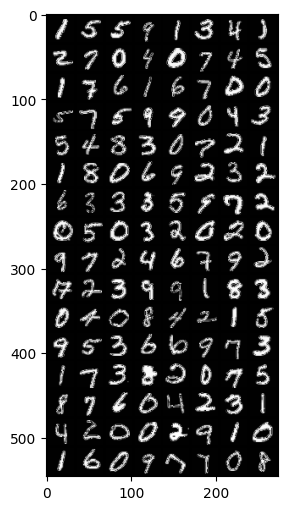

In [5]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm
- ReLU

In [6]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU,
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        # Dernière couche : Transposed Convolution suivie d'une activation tanh
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.Tanh()
        )
    else:
        # Blocs intermédiaires : Transposed Convolution suivie de BatchNorm et ReLU
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU()
        )


class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        self.model = nn.Sequential(
            # First upscaling block
            get_upscaling_block(nz, ngf * 4, kernel=4, stride=1, padding=0),

            # Second upscaling block
            get_upscaling_block(ngf * 4, ngf * 2, kernel=4, stride=2, padding=1),

            # Third upscaling block
            get_upscaling_block(ngf * 2, ngf, kernel=4, stride=2, padding=1),

            # Final upscaling block (last layer with Tanh activation)
            get_upscaling_block(ngf, nchannels, kernel=4, stride=2, padding=1, last_layer=True)
        )

    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)

### 2.1.3. Sanity Tests

In [7]:
nz = 1000
z = torch.randn(batch_size, nz)

In [8]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

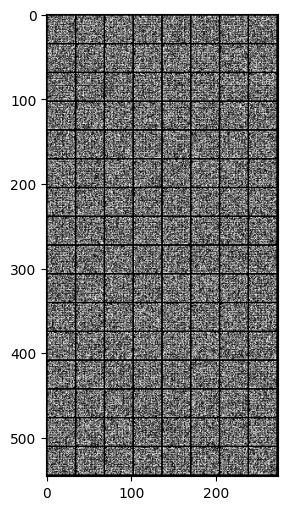

In [9]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))
plt.show()

## 2.2. The discriminator

The discriminator will be a mirror image of the generator.

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]`

In [10]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    if is_last:

        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.Sigmoid()
        )
    elif not use_batch_norm:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()
        self.model = nn.Sequential(
            # First upscaling block
            get_downscaling_block(1, ndf, kernel=4, stride=2, padding=1),

            # Second upscaling block
            get_downscaling_block(ndf, 2*ndf, kernel=4, stride=2, padding=1),

            # Third upscaling block
            get_downscaling_block(2*ndf, 3*ndf, kernel=4, stride=2, padding=1),

            # Final upscaling block (last layer with Tanh activation)
            get_downscaling_block(3*ndf, 1, kernel=4, stride=1, padding=0, is_last=True)
        )

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [11]:
real_batch, real_labels = next(iter(dataloader))

In [12]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

In [13]:
print(D(real_batch))

tensor([[0.6815],
        [0.6970],
        [0.5064],
        [0.5538],
        [0.6091],
        [0.5648],
        [0.6776],
        [0.5416],
        [0.6083],
        [0.7762],
        [0.5661],
        [0.6004],
        [0.5278],
        [0.6024],
        [0.6592],
        [0.6635],
        [0.5709],
        [0.5120],
        [0.6782],
        [0.5803],
        [0.6039],
        [0.6273],
        [0.6363],
        [0.5874],
        [0.5097],
        [0.6582],
        [0.5194],
        [0.5113],
        [0.7130],
        [0.4750],
        [0.6251],
        [0.5410],
        [0.4868],
        [0.6449],
        [0.5609],
        [0.5603],
        [0.5595],
        [0.5797],
        [0.4766],
        [0.8066],
        [0.6372],
        [0.5698],
        [0.6237],
        [0.5776],
        [0.6641],
        [0.7584],
        [0.5029],
        [0.5882],
        [0.5792],
        [0.5237],
        [0.4292],
        [0.5774],
        [0.6952],
        [0.6117],
        [0.6431],
        [0

# 3. Training

## 3.1 Loss
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [14]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions.
1. First, we need to continuously sample z from a Gaussian distribution.
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s.

In [15]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1)
    return r.to(device)

# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [16]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training!
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve.
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 0.8870124220848083; d_loss: 1.570502519607544; avg_real_score: 0.4501577615737915; avg_fake_score: 0.428157240152359: : 0it [00:01, ?it/s]

generated images


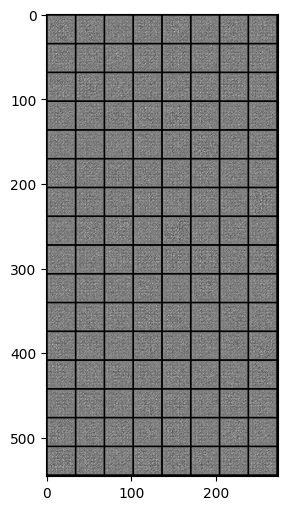

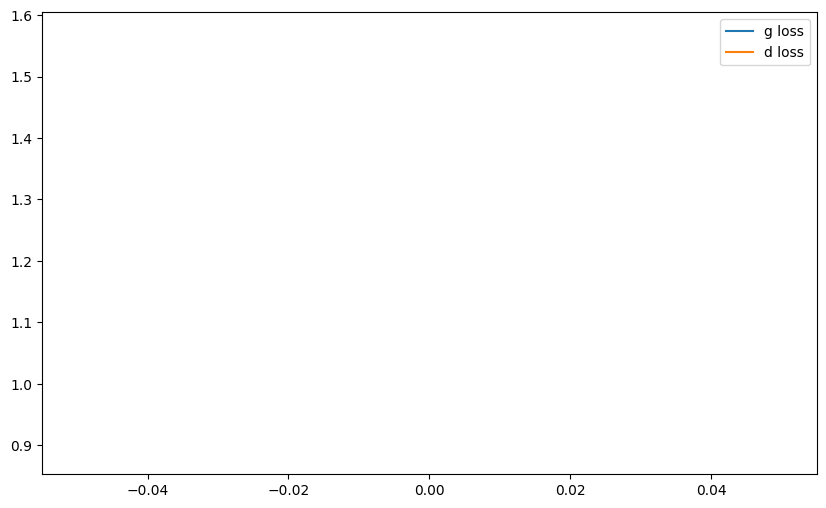

it: 200; g_loss: 0.7060174345970154; d_loss: 0.7799714207649231; avg_real_score: 0.5612311363220215; avg_fake_score: 0.5086402297019958: : 200it [03:50,  1.13s/it] 

generated images


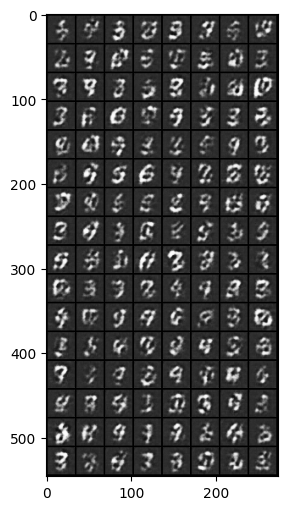

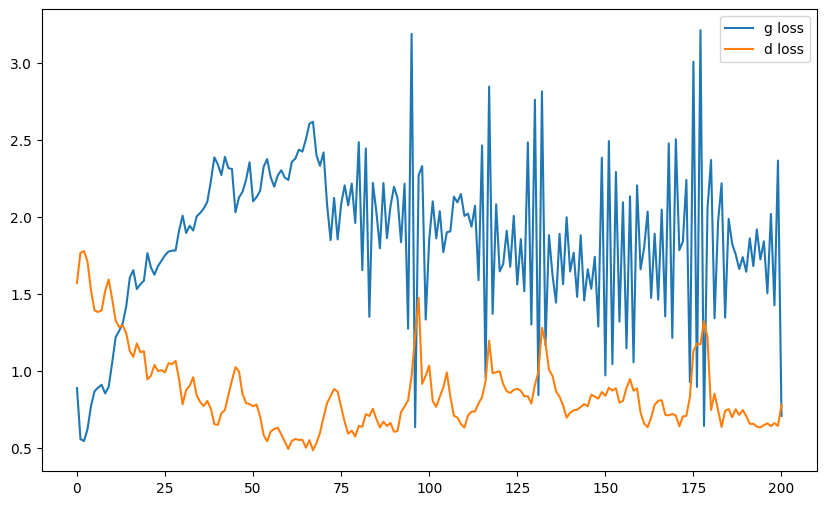

it: 400; g_loss: 0.7286721467971802; d_loss: 1.4773204326629639; avg_real_score: 0.27616676688194275; avg_fake_score: 0.5028234124183655: : 400it [07:29,  1.16s/it] 

generated images


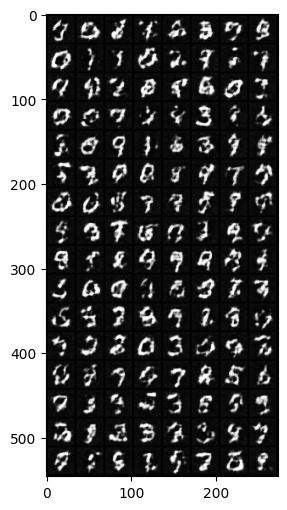

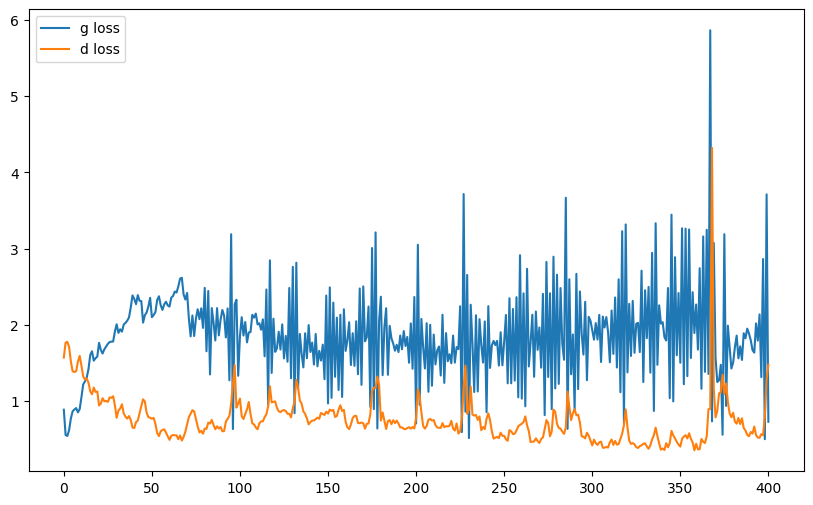

it: 468; g_loss: 0.6211187243461609; d_loss: 0.9890530109405518; avg_real_score: 0.4175908863544464; avg_fake_score: 0.5510120987892151: : 469it [08:43,  1.12s/it]
it: 469; g_loss: 2.349463701248169; d_loss: 0.9068303108215332; avg_real_score: 0.9222931861877441; avg_fake_score: 0.10685977339744568: : 0it [00:00, ?it/s]

generated images


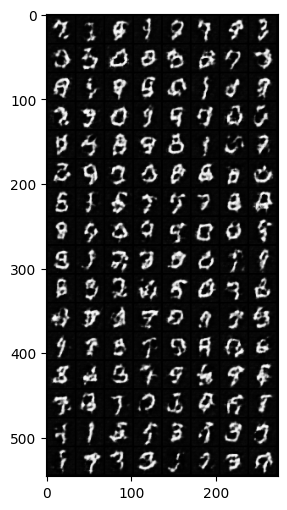

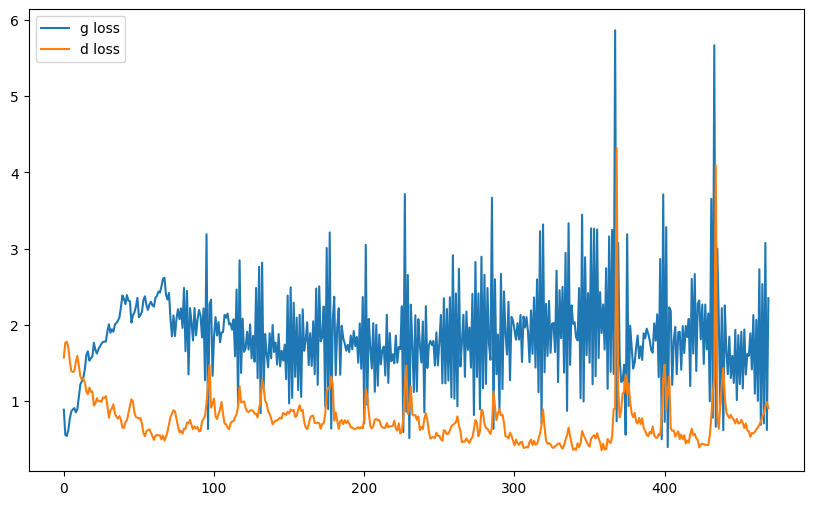

it: 669; g_loss: 2.484682321548462; d_loss: 1.4368500709533691; avg_real_score: 0.9239224195480347; avg_fake_score: 0.0910317525267601: : 200it [03:39,  1.13s/it]  

generated images


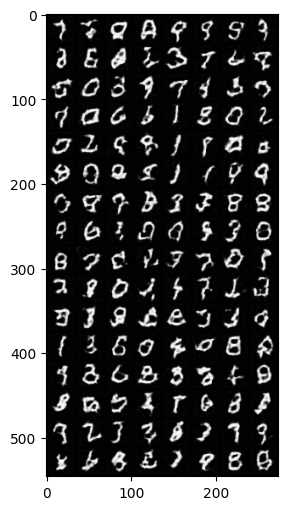

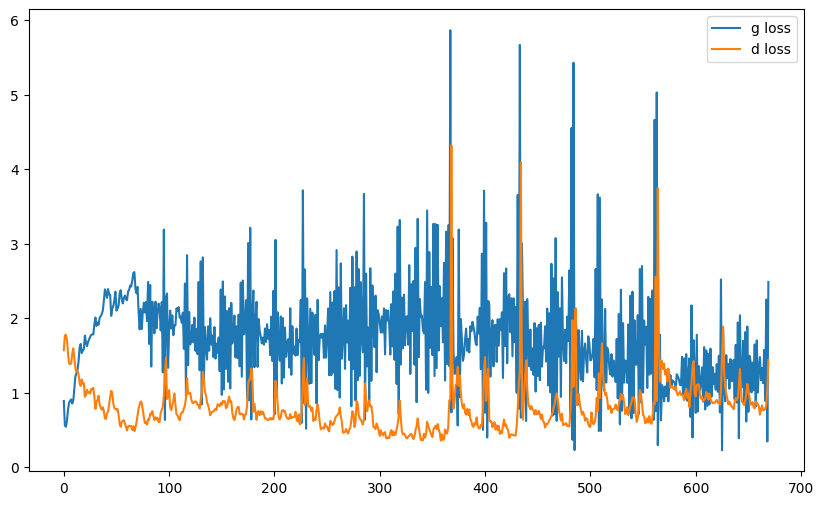

it: 869; g_loss: 1.9654163122177124; d_loss: 0.7068598866462708; avg_real_score: 0.7497714757919312; avg_fake_score: 0.15358801186084747: : 400it [07:20,  1.07s/it]

generated images


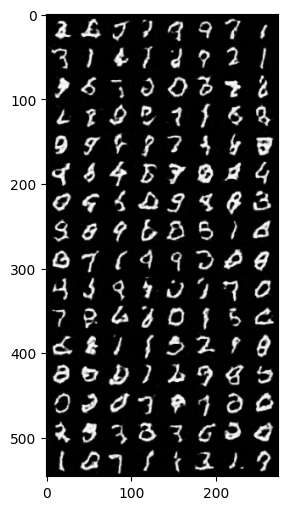

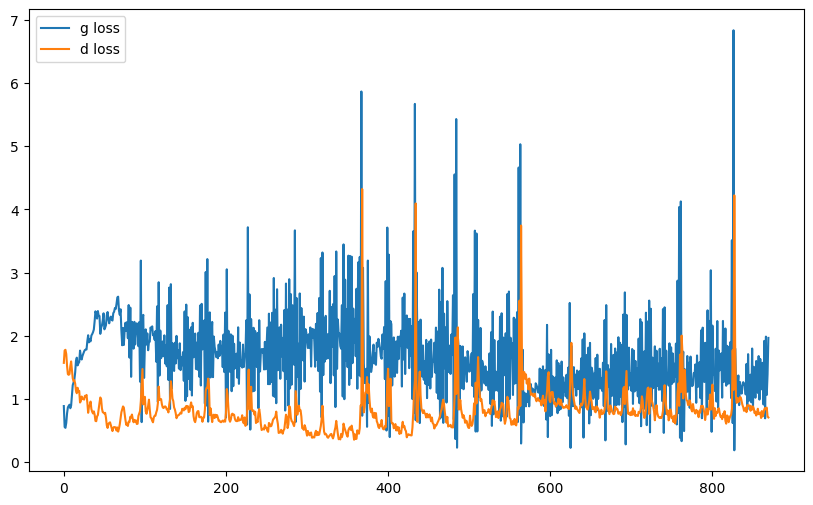

it: 937; g_loss: 1.1635833978652954; d_loss: 0.6989714503288269; avg_real_score: 0.6729302406311035; avg_fake_score: 0.3270028829574585: : 469it [08:35,  1.10s/it]
it: 938; g_loss: 1.8003408908843994; d_loss: 0.5871403217315674; avg_real_score: 0.8017734289169312; avg_fake_score: 0.1795978993177414: : 0it [00:01, ?it/s]

generated images


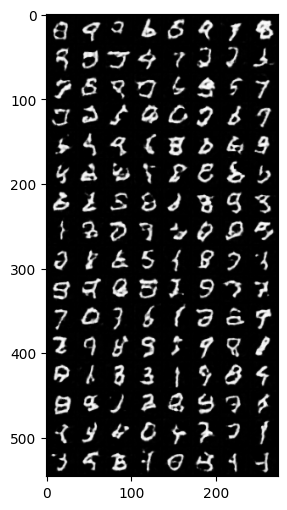

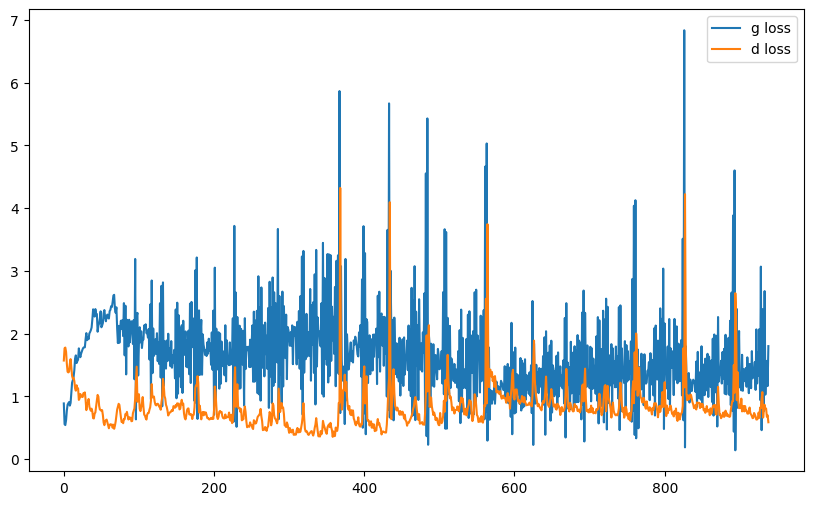

it: 1138; g_loss: 1.9880114793777466; d_loss: 0.5550177097320557; avg_real_score: 0.81157386302948; avg_fake_score: 0.14942172169685364: : 200it [03:42,  1.13s/it] 

generated images


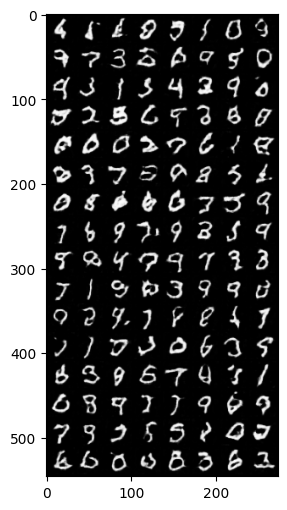

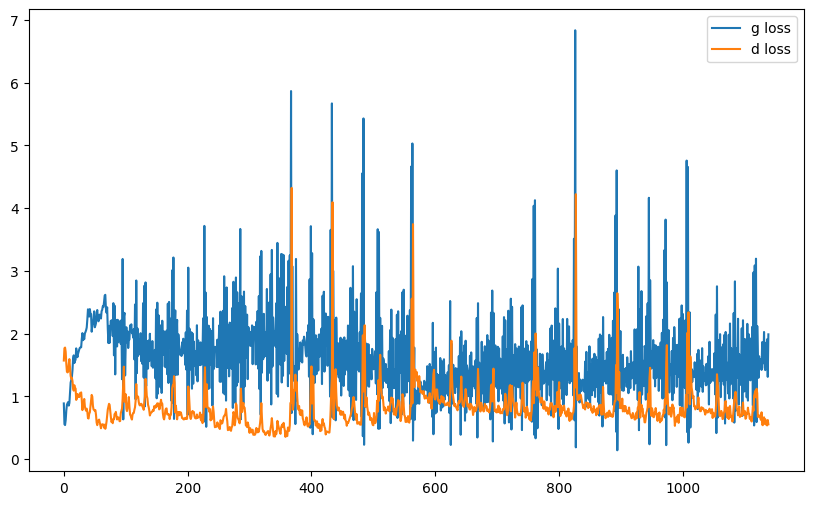

it: 1338; g_loss: 0.8679258823394775; d_loss: 0.7517995834350586; avg_real_score: 0.547563910484314; avg_fake_score: 0.44070419669151306: : 400it [07:16,  1.05s/it] 

generated images


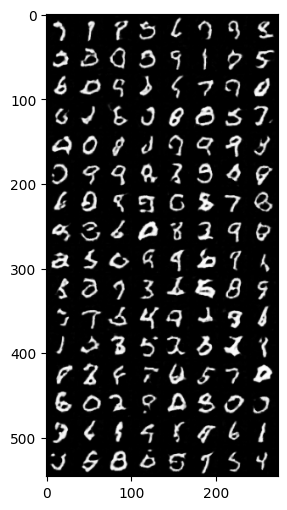

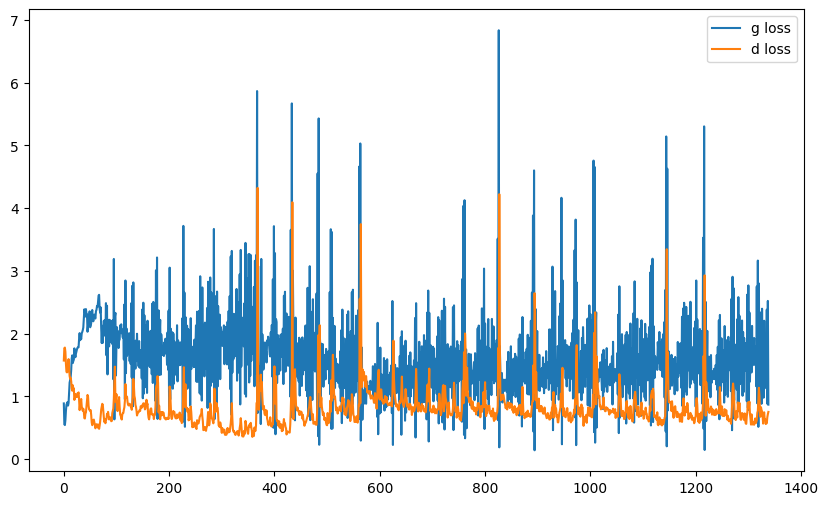

it: 1406; g_loss: 0.8872458338737488; d_loss: 0.6637225151062012; avg_real_score: 0.6681733131408691; avg_fake_score: 0.4343261420726776: : 469it [08:33,  1.09s/it]
it: 1407; g_loss: 3.133030891418457; d_loss: 0.6808253526687622; avg_real_score: 0.90811687707901; avg_fake_score: 0.05204661190509796: : 0it [00:01, ?it/s]

generated images


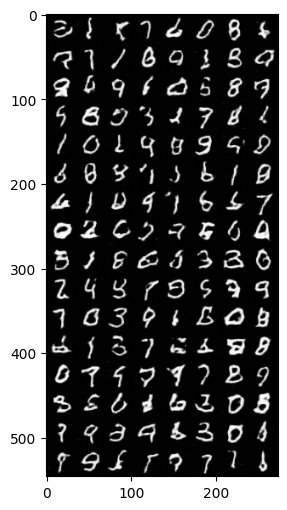

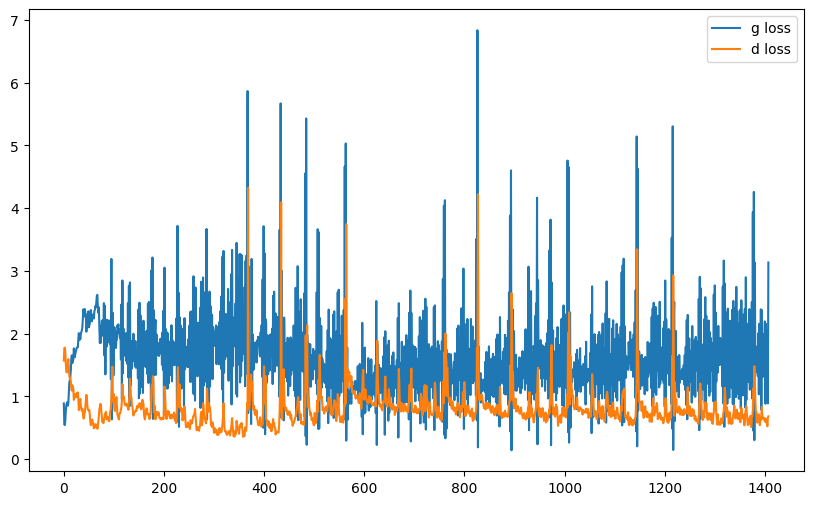

it: 1607; g_loss: 0.9378491640090942; d_loss: 1.0831351280212402; avg_real_score: 0.4445876181125641; avg_fake_score: 0.4158286154270172: : 200it [03:42,  1.04s/it]

generated images


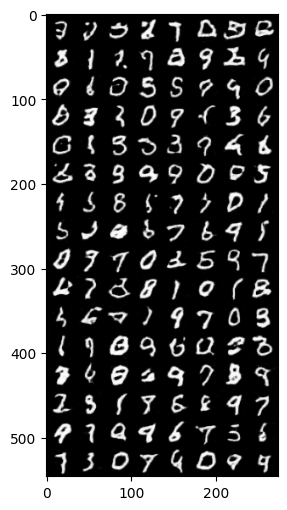

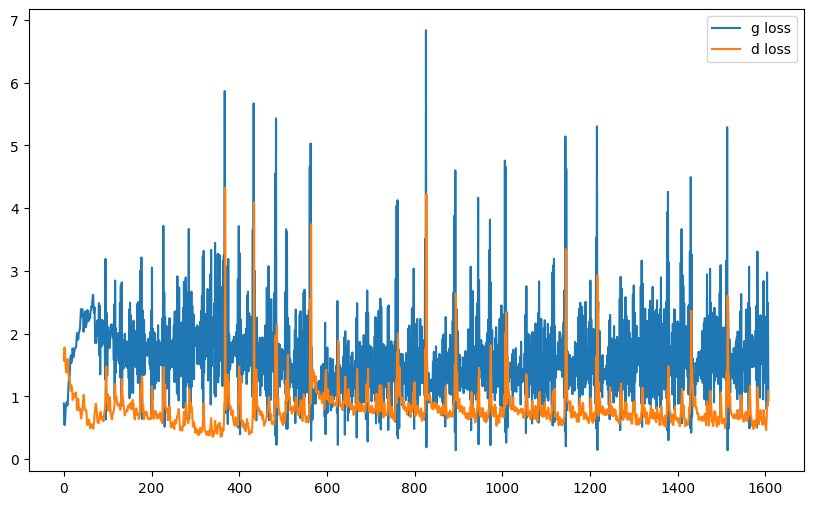

it: 1807; g_loss: 1.1330673694610596; d_loss: 0.624279260635376; avg_real_score: 0.6559306979179382; avg_fake_score: 0.3420569896697998: : 400it [07:24,  1.06s/it]

generated images


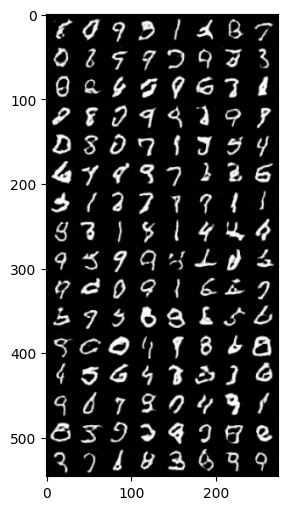

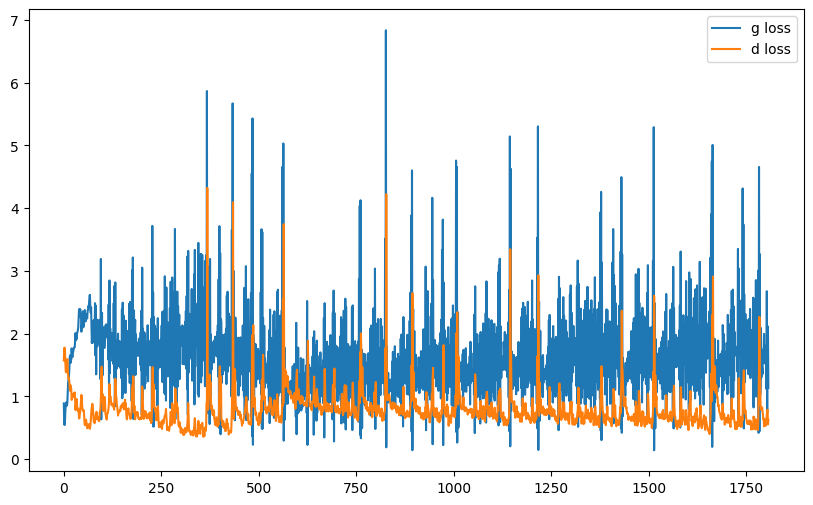

it: 1875; g_loss: 2.2235805988311768; d_loss: 0.611007571220398; avg_real_score: 0.8150021433830261; avg_fake_score: 0.1272141933441162: : 469it [08:38,  1.11s/it]
it: 1876; g_loss: 1.687203288078308; d_loss: 0.4871249198913574; avg_real_score: 0.7392619252204895; avg_fake_score: 0.20829704403877258: : 0it [00:01, ?it/s]

generated images


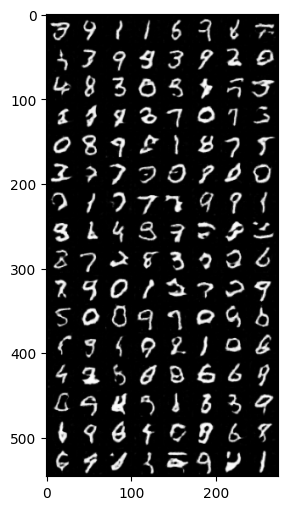

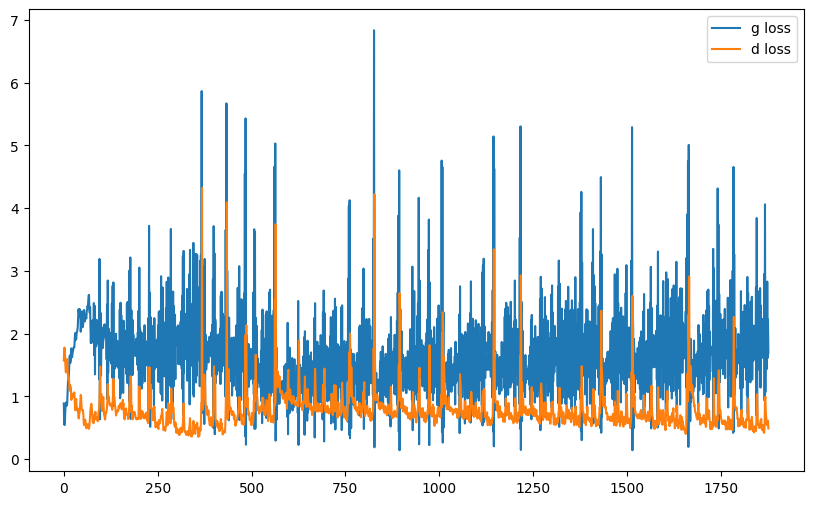

it: 2076; g_loss: 1.454709768295288; d_loss: 0.5223657488822937; avg_real_score: 0.7155327796936035; avg_fake_score: 0.2613421082496643: : 200it [03:41,  1.08s/it] 

generated images


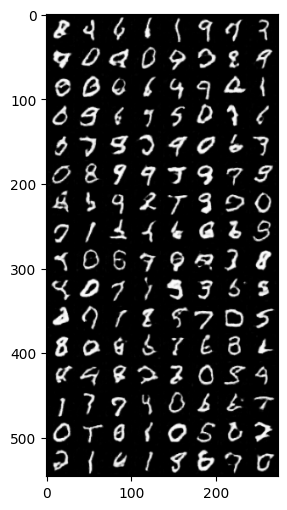

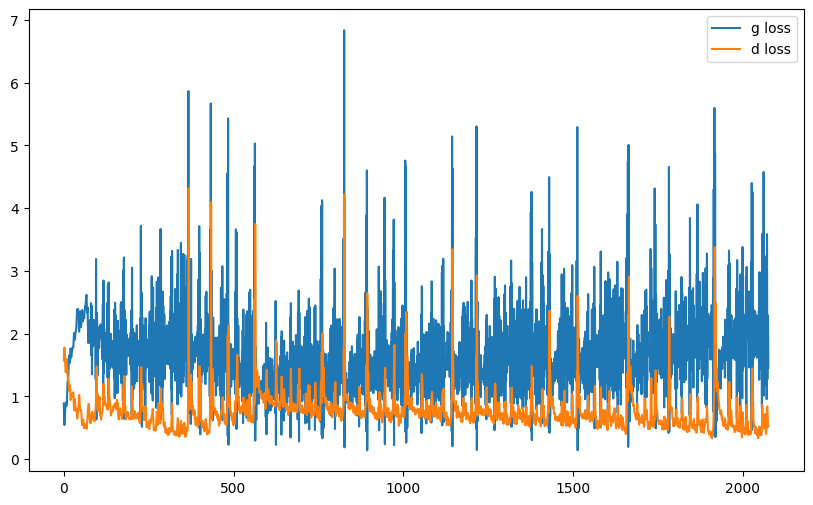

it: 2276; g_loss: 0.9415423274040222; d_loss: 0.8908050060272217; avg_real_score: 0.4734717011451721; avg_fake_score: 0.42546403408050537: : 400it [07:26,  1.11s/it]

generated images


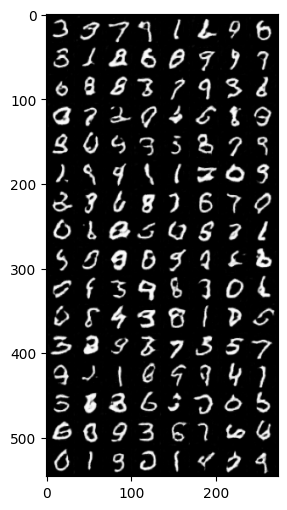

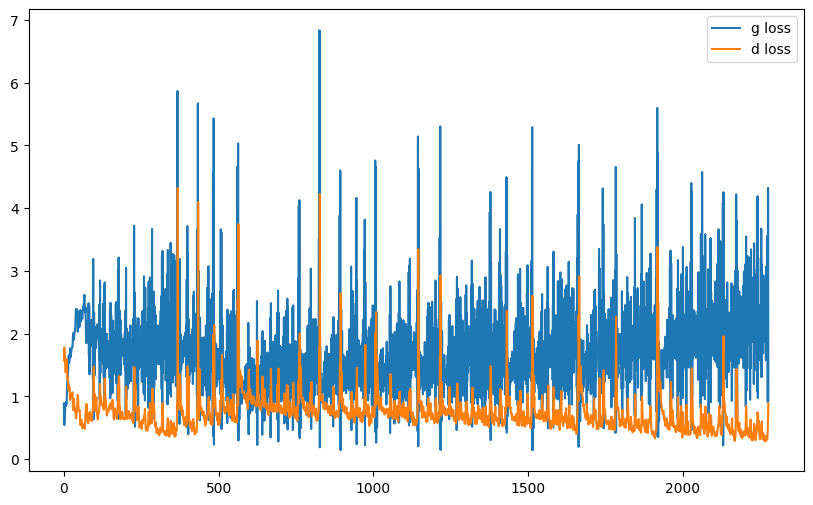

it: 2344; g_loss: 2.290597677230835; d_loss: 0.3022422790527344; avg_real_score: 0.8505990505218506; avg_fake_score: 0.11951851844787598: : 469it [08:40,  1.11s/it]


In [17]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz).to(device)

        # 2. Generate a fake image
        x_fake = netG(z)

        # 3. Classify real image with D
        y_ones = get_labels_one(cur_batch_size).to(device)
        predictions_1 = netD(im)
        loss_real = criterion(predictions_1, y_ones)

        # 4. Classify fake image with D
        y_zeros = get_labels_zero(cur_batch_size).to(device)
        predictions_0 = netD(x_fake)
        loss_fake = criterion(predictions_0, y_zeros)

        ### Discriminator
        d_loss = loss_fake + loss_real
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        ### Generator
        y_ones = get_labels_one(cur_batch_size).to(device)
        predictions_0 = netD(x_fake)
        g_loss = criterion(predictions_0, y_ones)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        # Save Metrics
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = predictions_1.mean().item()
        avg_fake_score = predictions_0.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            #fake_im = G(z_test)

            un_norm = renorm(x_fake) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

## 3.4. CIFAR-10 Training

In [18]:
class Generator_Cifar10(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        self.model = nn.Sequential(
            # First upscaling block
            get_upscaling_block(nz, ngf * 8, kernel=4, stride=1, padding=0),

            # Second upscaling block
            get_upscaling_block(ngf * 8, ngf * 4, kernel=4, stride=2, padding=1),

            # Third upscaling block
            get_upscaling_block(ngf * 4, ngf * 2, kernel=4, stride=2, padding=1),

            # New Layer 1: Additional processing
            nn.Conv2d(ngf * 2, ngf * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),

            # New Layer 2: Additional processing
            nn.Conv2d(ngf * 2, ngf * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),

            # Final upscaling block
            get_upscaling_block(ngf * 2, nchannels, kernel=4, stride=2, padding=1, last_layer=True)
        )

    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2)  # Give spatial dimensions to z
        return self.model(x)

class Discriminator_Cifar10(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()
        self.model = nn.Sequential(
            # First downscaling block
            get_downscaling_block(nchannels, ndf, kernel=4, stride=2, padding=1),

            # Second downscaling block
            get_downscaling_block(ndf, 2 * ndf, kernel=4, stride=2, padding=1),

            # New Layer 1: Additional processing
            nn.Conv2d(2 * ndf, 2 * ndf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(2 * ndf),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # Third downscaling block
            get_downscaling_block(2 * ndf, 3 * ndf, kernel=4, stride=2, padding=1),

            # New Layer 2: Additional processing
            nn.Conv2d(3 * ndf, 3 * ndf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(3 * ndf),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # Final downscaling block
            get_downscaling_block(3 * ndf, 1, kernel=4, stride=1, padding=0, is_last=True)
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(x.size(0), -1)  # Flatten the output to (batch_size, 1)

In [19]:
# Define the transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 256x256
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()  # Convert to tensor
])

# Download and load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_pipeline)

# Define the DataLoader for batching the data
batch_size = 128  # Batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:01<00:00, 94.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [20]:
nz = 10000
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator_Cifar10(ndf, nchannels).to(device)
netG = Generator_Cifar10(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 10

g_losses = []
d_losses = []

j = 0

z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    # train
    pbar = tqdm(enumerate(train_loader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz).to(device)

        # 2. Generate a fake image
        x_fake = netG(z)

        # 3. Classify real image with D
        y_ones = get_labels_one(cur_batch_size).to(device)
        predictions_1 = netD(im)
        loss_real = criterion(predictions_1, y_ones)

        # 4. Classify fake image with D
        y_zeros = get_labels_zero(cur_batch_size).to(device)
        predictions_0 = netD(x_fake)
        loss_fake = criterion(predictions_0, y_zeros)

        ### Discriminator
        d_loss = loss_fake + loss_real
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        ### Generator
        y_ones = get_labels_one(cur_batch_size).to(device)
        predictions_0 = netD(x_fake)
        g_loss = criterion(predictions_0, y_ones)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        # Save Metrics
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = predictions_1.mean().item()
        avg_fake_score = predictions_0.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:
            # Fake images: select a subset for visualization
            un_norm = renorm(x_fake)  # Un-normalize the generated images
            subset = un_norm[:3]  # Select the first 3 images from the batch

            grid = torchvision.utils.make_grid(subset, nrow=3)  # Arrange in a single row
            pil_grid = to_pil(grid)

            print("Generated images:")
            plt.imshow(pil_grid)
            plt.axis('off')  # Hide axis for better visualization
            plt.title(f'Epoch {epoch}')  # Ajouter le numéro de l'époque dans le titre
            plt.show()

            # Plot Generator and Discriminator losses
            plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
            plt.plot(range(len(g_losses)), d_losses, label='Discriminator Loss')

            plt.legend()
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            plt.show()

        j += 1

## 3.4. Sheep training

In [ ]:
# Transformation
mytransform = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionner à 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normaliser entre [-1, 1] pour tanh
])

# Télécharger le fichier numpy correspondant
url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy'
!wget {url} -O sheep.npy

# Charger les données
data = np.load('sheep.npy')  # (num_samples, 784)

# Reshaper les données pour correspondre aux dimensions d'image
data = data.reshape((-1, 28, 28))  # (num_samples, 28, 28)

# Définir un Dataset personnalisé pour appliquer mytransform
class QuickDrawDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype(np.uint8)  # Convertir en entier 8 bits
        image = Image.fromarray(image, mode='L')  # Convertir en image PIL (grayscale)

        if self.transform:
            image = self.transform(image)

        return image

# Créer le dataset avec les transformations
quickdraw_dataset = QuickDrawDataset(data, transform=mytransform)

# Créer le DataLoader
batch_size = 128
dataloader = DataLoader(dataset=quickdraw_dataset, batch_size=batch_size, shuffle=True)

# Tester le dataloader
for batch in dataloader:
    print(f"Taille d'un batch : {batch.size()}")
    break

In [ ]:
# Display the batch in the same style
for batch in dataloader:
    # Un-normalize the images (reverse normalization)
    un_norm = batch * 0.5 + 0.5  # Assuming the normalization used mean=0.5, std=0.5

    # Create a grid of images
    grid = torchvision.utils.make_grid(un_norm, nrow=8)  # Match nrow=8 as in your GAN visualization
    pil_grid = transforms.ToPILImage()(grid)  # Convert the grid to a PIL image for visualization

    print("Real images from the dataset")
    plt.imshow(pil_grid)
    plt.show()

    break  # Display only the first batch

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz).to(device)

        # 2. Generate a fake image
        x_fake = netG(z)

        # 3. Classify real image with D
        y_ones = get_labels_one(cur_batch_size).to(device)
        predictions_1 = netD(im)
        loss_real = criterion(predictions_1, y_ones)

        # 4. Classify fake image with D
        y_zeros = get_labels_zero(cur_batch_size).to(device)
        predictions_0 = netD(x_fake)
        loss_fake = criterion(predictions_0, y_zeros)

        ### Discriminator
        d_loss = loss_fake + loss_real
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        ### Generator
        y_ones = get_labels_one(cur_batch_size).to(device)
        predictions_0 = netD(x_fake)
        g_loss = criterion(predictions_0, y_ones)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = predictions_1.mean().item()
        avg_fake_score = predictions_0.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            #fake_im = G(z_test)

            un_norm = renorm(x_fake) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [ ]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()
        self.upscaling_z = get_upscaling_block(nz, ngf * 8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf * 8, 4, 1, 0)
        self.rest_model = nn.Sequential(
            get_upscaling_block(ngf * 16, ngf * 8, 4, 2, 1),  # ngf*8 + ngf*8 channel
            get_upscaling_block(ngf * 8, ngf * 4, 4, 2, 1),
            get_upscaling_block(ngf * 4, nchannels, 4, 2, 1, last_layer=True),
        )

    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        x = self.upscaling_z(x)

        y = y.unsqueeze(2).unsqueeze(2)
        y = self.upscaling_c(y)

        x = torch.cat((x, y), dim=1)
        return self.rest_model(x)

### 4.1.2 Discriminator

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.ndf = ndf
        self.downscale_x = get_downscaling_block(
            nchannels, ndf * 2, 4, 2, 1, use_batch_norm=False
        )
        self.downscale_y = get_downscaling_block(
            nc, ndf * 2, 4, 2, 1, use_batch_norm=False
        )
        self.rest = nn.Sequential(
            get_downscaling_block(
                ndf * 4, ndf * 8, 4, 2, 1
            ),  # input = ndf*2 + ndf*2 concatenation of downscale_x / y
            get_downscaling_block(ndf * 8, ndf * 16, 4, 2, 1),
            get_downscaling_block(ndf * 16, 1, 4, 1, 0, is_last=True),
        )

    def forward(self, x, y):
        y = y.unsqueeze(2).unsqueeze(2).expand(-1, -1, self.ndf, self.ndf)
        y = self.downscale_y(y)
        x = self.downscale_x(x)

        x = torch.cat((x, y), dim=1)
        return self.rest(x).squeeze(1).squeeze(1)  # remove spatial dimensions

### 4.1.3 Sanity Checks

In [ ]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [ ]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

## 4.2 Training

In [ ]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing

for epoch in range(nb_epochs):
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch
        im = im.to(device)

        y = F.one_hot(labels).float().to(device)

        cur_batch_size = im.shape[0]
        # 1. sample a z vector
        x = sample_z(cur_batch_size, nz)
        # 2. Generate a fake image
        x = netG(x, y)
        # 3. Classify real image with D
        yhat_real = netD(im, y)
        loss_D_real = criterion(yhat_real, get_labels_one(cur_batch_size))
        # 4. Classify fake image with D
        yhat_fake = netD(x, y)
        loss_D_fake = criterion(yhat_fake, get_labels_zero(cur_batch_size))

        ### Discriminator
        d_loss = loss_D_real + loss_D_fake
        d_opt.zero_grad()
        d_loss.backward(
            retain_graph=True
        )  # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        ### Generator
        g_loss = criterion(netD(x, y), get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(
            f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}"
        )

        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)

            un_norm = renorm(fake_im)

            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)

            plt.imshow(pil_grid)
            plt.axis("off")
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label="g loss")
            plt.plot(range(len(g_losses)), d_losses, label="d loss")

            plt.legend()
            plt.show()

        j += 1

## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

In [ ]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)

plt.imshow(pil_grid)
plt.show()
